*Взять новостные данные из https://github.com/natasha/corus load_lenta2. Нам  
понадобится сам текст и заголовок. Обучить модель T5/ или GPT для генерации заголовков для статей.*

В этом задании возьмём готовую модель Т5 и дообучим её  
под нашу задачу.

Ссылка на скачивание датасета:

In [1]:
# !wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2

Загрузим библиотеки и датасет:

In [1]:
%matplotlib inline

from corus import load_lenta2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torchinfo import summary
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [2]:
RANDOM_STATE = 29

In [3]:
path = 'lenta-ru-news.csv.bz2'
records = load_lenta2(path)

In [4]:
next(records)

LentaRecord(
    url='https://lenta.ru/news/1914/09/16/hungarnn/',
    title='1914. Русские войска вступили в\xa0пределы Венгрии  ',
    text='Бои у Сопоцкина и Друскеник закончились отступлением германцев. Неприятель, приблизившись с севера к Осовцу начал артиллерийскую борьбу с крепостью. В артиллерийском бою принимают участие тяжелые калибры. С раннего утра 14 сентября огонь достиг значительного напряжения. Попытка германской пехоты пробиться ближе к крепости отражена. В Галиции мы заняли Дембицу. Большая колонна, отступавшая по шоссе от Перемышля к Саноку, обстреливалась с высот нашей батареей и бежала, бросив парки, обоз и автомобили. Вылазки гарнизона Перемышля остаются безуспешными. При продолжающемся отступлении австрийцев обнаруживается полное перемешивание их частей, захватываются новые партии пленных, орудия и прочая материальная часть. На перевале Ужок мы разбили неприятельский отряд, взяли его артиллерию и много пленных и, продолжая преследовать, вступили в пределы Венгрии

В качестве модели возьмём базовую версию мультиязычной Т5,  
из которой были удалены языки, кроме русского и английского.

In [6]:
model_name = 'cointegrated/rut5-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

Загрузим весь датасет в память:

In [7]:
dataset = [(record.text, record.title) for record in records]

In [8]:
dataset = pd.DataFrame(dataset, columns=['text', 'title'])
dataset.shape

(800974, 2)

In [9]:
dataset.head()

,text,title
0,"Министерство народного просвещения, в виду про...",1914. Празднование столетия М.Ю. Лермонтова от...
1,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",1914. Das ist Nesteroff!
2,Фотограф-корреспондент Daily Mirror рассказыва...,1914. Бульдог-гонец под Льежем
3,"Лица, приехавшие в Варшаву из Люблина, передаю...",1914. Под Люблином пойман швабский зверь
4,Как стало известно агентству Ассошиэйтед Пресс...,"Космонавты сомневаются в надежности ""Мира"""


Для более быстрого обучения возьмём только 10000 строк:

In [10]:
dataset = dataset.sample(10000, random_state=RANDOM_STATE)

Разделим на обучающую и тестовую выборки, чтобы на тестовой  
можно было проверить результаты работы модели:

In [11]:
data_train, data_test = train_test_split(dataset, test_size=0.05, random_state=RANDOM_STATE)

In [12]:
data_test.shape

(500, 2)

Посмотрим на распределение длин токенов в текстах:

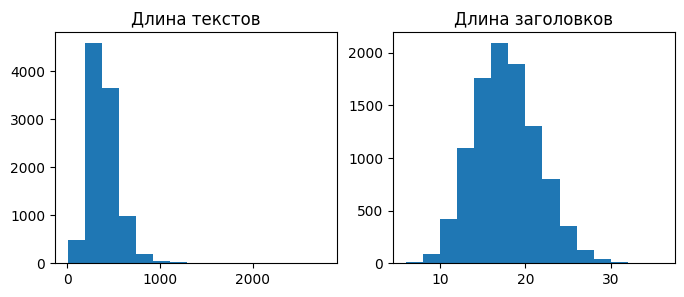

In [13]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.hist([len(tokenizer.encode(data)) for data in dataset['text']], bins=15)
plt.title('Длина текстов')

plt.subplot(1, 2, 2)
plt.hist([len(tokenizer.encode(data)) for data in dataset['title']], bins=15)
plt.title('Длина заголовков')

plt.show()

Тексты достаточно длинные, зададимся следующими числами:

In [14]:
MAX_TEXT_LEN = 1024
MAX_TITLE_LEN = 32

Напишем класс датасета. Объединим инпуты и таргеты в один словарь,  
так модель будет сама рассчитывать лосс.

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
class NewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):    
        
        self.dataset = dataset
        
        self.texts = tokenizer(self.dataset['text'].tolist(), padding=True, truncation=True, 
                               max_length=MAX_TEXT_LEN, return_tensors='pt')
        
        self.titles = tokenizer(self.dataset['title'].tolist(), padding=True, truncation=True, 
                                max_length=MAX_TITLE_LEN, return_tensors='pt', return_attention_mask=False)
        
    def __getitem__(self, index):
        example = {k: v[index].to(device) for k, v in self.texts.items()}
        example['labels'] = self.titles['input_ids'][index].to(device)
        return example
    
    def __len__(self):
        return len(self.dataset)

Посмотрим на модель:

In [17]:
summary(model)

Layer (type:depth-idx)                                       Param #
T5ForConditionalGeneration                                   --
├─Embedding: 1-1                                             23,040,000
├─T5Stack: 1-2                                               23,040,000
│    └─Embedding: 2-1                                        (recursive)
│    └─ModuleList: 2-2                                       --
│    │    └─T5Block: 3-1                                     7,079,808
│    │    └─T5Block: 3-2                                     7,079,424
│    │    └─T5Block: 3-3                                     7,079,424
│    │    └─T5Block: 3-4                                     7,079,424
│    │    └─T5Block: 3-5                                     7,079,424
│    │    └─T5Block: 3-6                                     7,079,424
│    │    └─T5Block: 3-7                                     7,079,424
│    │    └─T5Block: 3-8                                     7,079,424
│    │    └─T5Bloc

Учитывая громоздкость модели и приличную длину текстов, размер батча  
больше 1 приводит к ошибке нехватки памяти:

In [18]:
BATCH_SIZE = 1

Создадим даталоадер:

In [19]:
train_dataset = NewsDataset(data_train)

In [20]:
torch.random.manual_seed(RANDOM_STATE)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

Обучим модель. Обучать будем только последний линейный слой, т.к. даже  
обучение одного слоя занимает довольно приличное время. Также добавление  
других слоёв в обучение приводит к ошибке нехватки памяти.

In [19]:
EPOCHS = 3

torch.random.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

model = model.to(device)

optimizer = torch.optim.Adam(model.lm_head.parameters(), lr=1e-5)

for epoch in range(EPOCHS):
    
    losses = 0.
    
    for data in tqdm(train_loader):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(**data)

        loss = outputs.loss
        losses += outputs.loss.item()
        loss.backward()
        optimizer.step()
    
    model.save_pretrained('./t5_model/')
    print(f'Epoch [{epoch + 1}/{EPOCHS}]. ' \
          f'Train Loss: {losses / len(train_loader):.3f}.')

print('Training is finished!')

100%|███████████████████████████████████████| 9500/9500 [31:46<00:00,  4.98it/s]


Epoch [1/3]. Train Loss: 18.991.


100%|███████████████████████████████████████| 9500/9500 [31:35<00:00,  5.01it/s]


Epoch [2/3]. Train Loss: 8.073.


100%|███████████████████████████████████████| 9500/9500 [31:34<00:00,  5.01it/s]


Epoch [3/3]. Train Loss: 7.279.
Training is finished!


К сожалению, модели нужно больше эпох обучения, поэтому придётся  
её дообучить. Так как я изначально думал, что трёх эпох будет  
достаточно, то оформил код обучения не в виде функции, как это  
обычно делаю, а просто кодом. Поэтому придётся немного продублировать  
код, чтобы не менять уже запущенный код и не затирать аутпуты с прогрессом.  
Снизим в 2 раза скорость обучения, т.к. оптимизатор Adam её постепенно  
снижает, и мы не знаем, на каком значении остановилось обучение.

In [21]:
model = AutoModelForSeq2SeqLM.from_pretrained('./t5_model/')

In [60]:
EPOCHS = 5

torch.random.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

model = model.to(device)

optimizer = torch.optim.Adam(model.lm_head.parameters(), lr=5e-6)

for epoch in range(EPOCHS):
    
    losses = 0.
    
    for data in tqdm(train_loader):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(**data)

        loss = outputs.loss
        losses += outputs.loss.item()
        loss.backward()
        optimizer.step()
    
    model.save_pretrained('./t5_model/')
    print(f'Epoch [{epoch + 1}/{EPOCHS}]. ' \
          f'Train Loss: {losses / len(train_loader):.3f}.')

print('Training is finished!')

100%|███████████████████████████████████████| 9500/9500 [31:31<00:00,  5.02it/s]


Epoch [1/5]. Train Loss: 7.025.


100%|███████████████████████████████████████| 9500/9500 [31:27<00:00,  5.03it/s]


Epoch [2/5]. Train Loss: 6.894.


100%|███████████████████████████████████████| 9500/9500 [31:21<00:00,  5.05it/s]


Epoch [3/5]. Train Loss: 6.779.


100%|███████████████████████████████████████| 9500/9500 [32:29<00:00,  4.87it/s]


Epoch [4/5]. Train Loss: 6.676.


100%|███████████████████████████████████████| 9500/9500 [31:52<00:00,  4.97it/s]


Epoch [5/5]. Train Loss: 6.588.
Training is finished!


Посмотрим, как модель будет генерировать. Лосс, конечно, великоват.

In [22]:
def generate_title(index):
    
    model.eval()
    
    text = data_test.iloc[index]['text']
    
    generated_title = model.cpu().generate(
           **tokenizer(text, return_tensors='pt'),
           pad_token_id=model.config.pad_token_id,
           eos_token_id=model.config.eos_token_id,
           max_new_tokens=32,
           do_sample=True,
           temperature=1.0,
           # num_beams=20,
           top_k=5,
           repetition_penalty=5.
           )
    
    generated_title = tokenizer.decode(generated_title[0], skip_special_tokens=True)
    
    print(f'Текст:\n\n{text}\n')
    print(f'Сгенерированный заголовок:\n\n{generated_title}\n')
    print(f'Настоящий заголовок:\n\n{data_test.iloc[index]["title"]}\n')
    print('*' * 100, end='\n\n')

In [23]:
for i in torch.randint(low=0, high=len(data_test), size=(3,)):
    generate_title(i.item())

Текст:

Взрыв рядом с российскими бронеавтомобилями произошел в Сирии на границе с Турцией. Об этом заявили в российском Центре по примирению враждующих сторон, передает ТАСС. Инцидент произошел во время подготовки встречи представителей российской военной полиции и турецкой стороны на погранпереходе ад-Дербасийя (провинция Хасеке). В центре подчеркнули, что подорвалось неустановленное безоболочное взрывное устройство. Произошедшее назвали безуспешной провокацией с целью сорвать мероприятие. До этого в Минобороны опровергли информацию о том, что российский военный патруль попал под обстрел в районе погранперехода ад-Дербасийя. СМИ сообщали, что полицейские проезжали мимо, когда с турецкой стороны был открыт минометный огонь. Ранее в октябре на север Сирии прибыли дополнительные российские военные полицейские. В их задачи входит обеспечивание безопасности населения, поддержание правопорядка и патрулирование районов в 30-километровой зоне на границе с Турцией. 22 октября президент России

<ins>Вывод:</ins>  
Дообучили предобученную модель Т5 под задачу суммаризации. Результат,  
мягко говоря, получился не очень хорошим. Предположу, что не хватило  
эпох обучения. Также непонятно, насколько хорошо подобран коэффициент  
скорости обучения, возможно, стоило его повысить. Учитывая, что каждая  
эпоха обучается полчаса, то особо не было времени поэкспериментировать  
с гиперпараметрами. Датасет и модель оказались очень требовательными к  
ресурсам. Несмотря на неплохую видеокарту с не самым маленьким объёмом  
видеопамяти (8 ГБ), в неё смог влезть только батч размером в единицу.